In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import nltk
import re
from wordcloud import WordCloud

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [3]:
df_fake = pd.read_csv("C:/Users/ramna/DataScience/Dissertation/DataSet/fake_real_news/Fake.csv")

In [4]:
df_fake.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
df_fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [6]:
df_fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

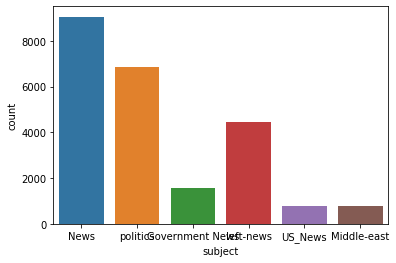

In [7]:
sb.countplot(x ='subject', data=df_fake)

# wordCloud

In [8]:
df_fake['text'].tolist()

['Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t e

In [9]:
type(df_fake['text'].tolist())

list

In [10]:
fake_txt = ' '.join(df_fake['text'].tolist())

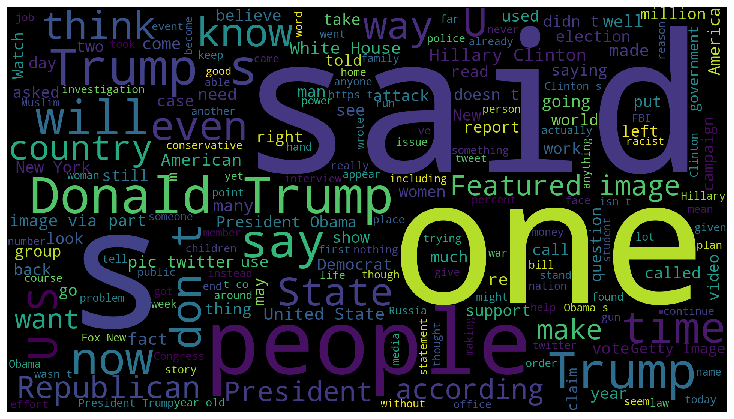

In [11]:
wc = WordCloud(width=1920, height=1080).generate(fake_txt)
fig = plt.figure(figsize=(10,10))
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=0)

# Real News

In [12]:
df_real = pd.read_csv("C:/Users/ramna/DataScience/Dissertation/DataSet/fake_real_news/True.csv")

In [13]:
df_real['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

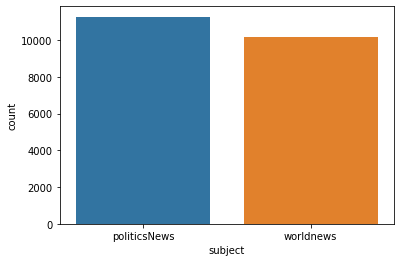

In [14]:
sb.countplot(x ='subject', data=df_real)

In [15]:
real_txt = ' '.join(df_real['text'].tolist())

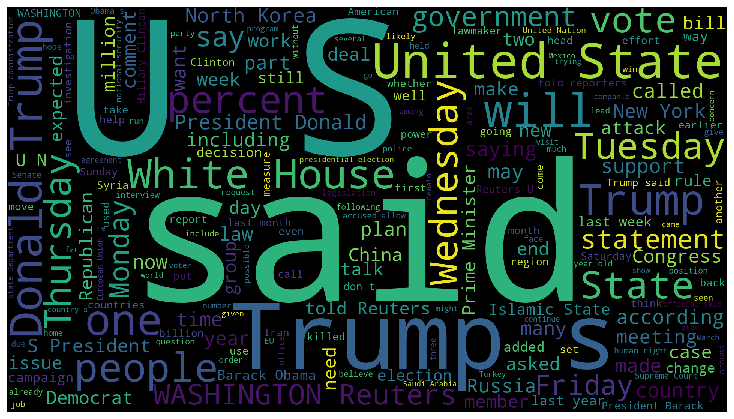

In [16]:
wc = WordCloud(width=1920, height=1080).generate(real_txt)
fig = plt.figure(figsize=(10,10))
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=0)

# Statistical Analysis of the dataset
Real news seems to have source of publication which is not present in fake news set

Looking at the data:
1. Most of text contains reuters information such as Washington (Reuters)
2. Some text are tweets form Twitter
3. Few text do not contain any publication info


# Data Cleaning

Removing Reuters or Twitter Tweet information from the text
1. Text can be splitted only at "-" which is always present after mentioning source of publication, this gives us publication and text part
2. If we do not get text part, this means publication details wasn't given for that record
3. The Twitter tweets always have some source, a long text of max 259 characters.

In [17]:
df_real.sample(5)

,title,text,subject,date
9601,Top House Democrat expects movement on Puerto ...,WASHINGTON (Reuters) - Democrats in the U.S. H...,politicsNews,"May 11, 2016"
16054,Spain's Supreme Court begins rebellion proceed...,MADRID (Reuters) - Spain s Supreme court has b...,worldnews,"October 31, 2017"
21173,Al Shabaab bomb kills 12 in Somalia's Puntland,"BOSSASO, Somalia (Reuters) - An al Shabaab bom...",worldnews,"September 1, 2017"
12478,'Furious race against time' to complete Brexit...,BRUSSELS (Reuters) - European Council Presiden...,worldnews,"December 12, 2017"
13309,"One dead, scores arrested in unrest over delay...",TEGUCIGALPA (Reuters) - At least one protester...,worldnews,"December 1, 2017"


In [18]:
# finding the unknown publishers in the data set
unknown_publishers = []
for index, row in enumerate(df_real.text.values):
    try:
        record = row.split('-', maxsplit=1)
        record[1]
        
        assert(len(record[0])<120)
    except:
        unknown_publishers.append(index)

In [19]:
len(unknown_publishers)

222

In [20]:
df_real.iloc[unknown_publishers]

,title,text,subject,date
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
12,Factbox: Trump on Twitter (Dec 28) - Vanity Fa...,The following statements were posted to the ve...,politicsNews,"December 28, 2017"
13,"Trump on Twitter (Dec 27) - Trump, Iraq, Syria",The following statements were posted to the ve...,politicsNews,"December 28, 2017"
14,Man says he delivered manure to Mnuchin to pro...,"(In Dec. 25 story, in second paragraph, corre...",politicsNews,"December 25, 2017"
...,...,...,...,...
20135,China's big money trumps U.S. influence in Cam...,(Story corrects to million from billion in pa...,worldnews,"September 11, 2017"
20500,UK publisher rejected request to block academi...,"(This Sept 8 story corrects headline, clarifi...",worldnews,"September 8, 2017"
20667,Rohingya say their village is lost to Myanmar'...,"(Story refiles to add dropped word not , in ...",worldnews,"September 7, 2017"
21246,'Gates of Hell': Iraqi army says fighting near...,(Story corrects third paragraph to show Mosul...,worldnews,"August 29, 2017"


In [21]:
df_real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [22]:
df_real = df_real.drop(8970, axis=0)

In [23]:
# finding the publishers in the data set
publisher = []
tmp_text = []

for index, row in enumerate(df_real.text.values):
    if index in unknown_publishers:
        tmp_text.append(row)
        publisher.append('UnKnown')
    
    else:
        record = row.split('-', maxsplit=1)
        publisher.append(record[0].strip())
        tmp_text.append(record[1].strip())

In [24]:
df_real['publisher'] = publisher
df_real['text'] = tmp_text

In [25]:
df_real.head(5)

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [26]:
df_real.shape

(21416, 5)

In [27]:
# checking fake dataset has empty text data
empty_fake_index = [index for index, text in enumerate(df_fake.text.tolist()) if str(text).strip()==""]

In [28]:
df_fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [29]:
df_real['text'] = df_real['title']+ " " +df_real['text']
df_fake['text'] = df_fake['title']+ " " +df_fake['text']

In [30]:
df_real.head(5)

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...","As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,U.S. military to accept transgender recruits o...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,Senior U.S. Republican senator: 'Let Mr. Muell...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,FBI Russia probe helped by Australian diplomat...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,Trump wants Postal Service to charge 'much mor...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [31]:
df_fake.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump Sends Out Embarrassing New Year’...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,Drunk Bragging Trump Staffer Started Russian ...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,Sheriff David Clarke Becomes An Internet Joke...,News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,Trump Is So Obsessed He Even Has Obama’s Name...,News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis Just Called Out Donald Trump Dur...,News,"December 25, 2017"


In [32]:
df_real['text'] = df_real['text'].apply(lambda x: str(x).lower())
df_fake['text'] = df_fake['text'].apply(lambda x: str(x).lower())

# PreProcessing Text

In [33]:
df_real['class'] = 1
df_fake['class'] = 0

In [34]:
df_real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [35]:
df_fake.columns

Index(['title', 'text', 'subject', 'date', 'class'], dtype='object')

In [36]:
df_real = df_real[['text', 'class']]

In [37]:
df_fake = df_fake[['text', 'class']]

In [38]:
data_ml_model = df_real.append(df_fake, ignore_index=True)

In [39]:
data_ml_model

,text,class
0,"as u.s. budget fight looms, republicans flip t...",1
1,u.s. military to accept transgender recruits o...,1
2,senior u.s. republican senator: 'let mr. muell...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1
...,...,...
44892,mcpain: john mccain furious that iran treated ...,0
44893,justice? yahoo settles e-mail privacy class-ac...,0
44894,sunnistan: us and allied ‘safe zone’ plan to t...,0
44895,how to blow $700 million: al jazeera america f...,0


In [40]:
def rm_spcl_chars(t):
    data_model = re.sub('[0-9!@#$;,.:!*%)(&^~]+','',t)
    return data_model

In [41]:
data_ml_model['text'] = data_ml_model['text'].apply(lambda x: rm_spcl_chars(x))

In [42]:
data_ml_model.head()

,text,class
0,as us budget fight looms republicans flip thei...,1
1,us military to accept transgender recruits on ...,1
2,senior us republican senator 'let mr mueller d...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1


In [57]:
# applying TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
cv_hashV = HashingVectorizer(n_features=2**4,norm=None,alternate_sign=False)
X = cv_hashV.fit_transform(data_ml_model['text']).toarray()

In [58]:
X.shape

(44897, 16)

In [59]:
y = data_ml_model['class']

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=0)

In [61]:
cv_hashV.get_params()

{'alternate_sign': False,
 'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'n_features': 16,
 'ngram_range': (1, 1),
 'norm': None,
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None}

In [62]:
count_df = pd.DataFrame(X)

In [63]:
count_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,36.0,39.0,28.0,28.0,37.0,39.0,20.0,50.0,38.0,32.0,28.0,77.0,63.0,57.0,118.0,36.0
1,21.0,34.0,27.0,19.0,47.0,15.0,17.0,42.0,29.0,27.0,27.0,65.0,42.0,63.0,88.0,50.0
2,27.0,34.0,15.0,26.0,24.0,21.0,7.0,31.0,15.0,17.0,15.0,35.0,63.0,41.0,68.0,16.0
3,20.0,22.0,7.0,18.0,25.0,19.0,4.0,22.0,20.0,18.0,22.0,34.0,34.0,51.0,49.0,13.0
4,54.0,44.0,34.0,50.0,41.0,33.0,24.0,59.0,56.0,40.0,28.0,71.0,70.0,71.0,112.0,38.0


In [64]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # MultinomialNB Algorithm

In [66]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()

In [67]:
from sklearn import metrics
import itertools

 Accuracy :: 0.667
Confusion matrix, without normalization


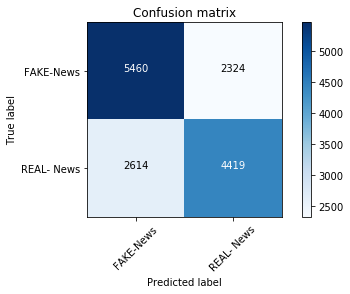

In [69]:
classifier.fit(X, y)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print(" Accuracy :: %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes= ['FAKE-News', 'REAL- News'])

In [70]:
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
accuracy_score = metrics.accuracy_score(y_test, pred)

In [71]:
accuracy_score

0.6659917662144834

# Passive Aggressive Algorithm

In [72]:
from sklearn.linear_model import PassiveAggressiveClassifier
passive_classifier = PassiveAggressiveClassifier()

 Accuracy :: 0.611
Confusion matrix, without normalization


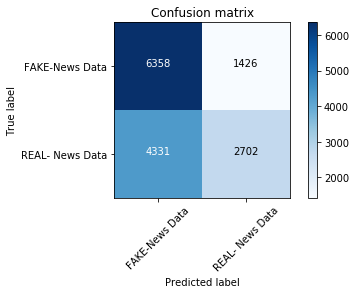

In [73]:
passive_classifier.fit(X, y)
pred = passive_classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print(" Accuracy :: %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes= ['FAKE-News Data', 'REAL- News Data'])

In [ ]:
print(classification_report(y_test, pred))

# Multinomial classifier Hyperparameter

In [74]:
classifier=MultinomialNB(alpha=0.1)

In [75]:
previous_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(X,y)
    y_pred=sub_classifier.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    if score>previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

Alpha: 0.0, Score : 0.666734156711885
Alpha: 0.1, Score : 0.666734156711885
Alpha: 0.2, Score : 0.666734156711885
Alpha: 0.30000000000000004, Score : 0.666734156711885
Alpha: 0.4, Score : 0.666734156711885
Alpha: 0.5, Score : 0.666734156711885
Alpha: 0.6000000000000001, Score : 0.666734156711885
Alpha: 0.7000000000000001, Score : 0.666734156711885
Alpha: 0.8, Score : 0.666734156711885
Alpha: 0.9, Score : 0.666734156711885


C:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [87]:
feature_names = cv_hashV.get_params()

In [88]:
classifier.coef_[0]

array([-2.99021389, -2.70541379, -3.24925852, -3.06589874, -2.87414809,
       -3.14309046, -3.19445578, -2.7929195 , -2.94521755, -3.08704563,
       -3.28935176, -2.42994617, -2.45097698, -2.34103771, -2.01637604,
       -2.87350739])

In [89]:
#Most Fake
sorted(zip(classifier.coef_[0], feature_names), reverse=True)[:20]

[(-2.016376038581999, 'token_pattern'),
 (-2.3410377090074395, 'strip_accents'),
 (-2.4299461653110708, 'preprocessor'),
 (-2.450976982982832, 'stop_words'),
 (-2.705413791781508, 'analyzer'),
 (-2.7929194976466007, 'lowercase'),
 (-2.873507391222132, 'tokenizer'),
 (-2.874148088322471, 'dtype'),
 (-2.9452175476612545, 'n_features'),
 (-2.990213892636591, 'alternate_sign'),
 (-3.0658987392734858, 'decode_error'),
 (-3.0870456316952968, 'ngram_range'),
 (-3.143090460125876, 'encoding'),
 (-3.19445578315805, 'input'),
 (-3.249258519464288, 'binary'),
 (-3.2893517599039583, 'norm')]

In [90]:
#Most Real
sorted(zip(classifier.coef_[0], feature_names))[:5000]

[(-3.2893517599039583, 'norm'),
 (-3.249258519464288, 'binary'),
 (-3.19445578315805, 'input'),
 (-3.143090460125876, 'encoding'),
 (-3.0870456316952968, 'ngram_range'),
 (-3.0658987392734858, 'decode_error'),
 (-2.990213892636591, 'alternate_sign'),
 (-2.9452175476612545, 'n_features'),
 (-2.874148088322471, 'dtype'),
 (-2.873507391222132, 'tokenizer'),
 (-2.7929194976466007, 'lowercase'),
 (-2.705413791781508, 'analyzer'),
 (-2.450976982982832, 'stop_words'),
 (-2.4299461653110708, 'preprocessor'),
 (-2.3410377090074395, 'strip_accents'),
 (-2.016376038581999, 'token_pattern')]